# F1 Visualizations

This notebook loads `ALLMerged.csv`, applies consistent team colors, and produces six core visualizations:

1. Start vs Finish (scatter)
2. Average Position Delta by Driver (bar)
3. Cumulative Team Points by Round (lines)
4. Team Standings Bump Chart (rank by round)
5. Qualifying Consistency by Team (boxplots)
6. Track Temperature vs Qualifying Pace (regression)

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

sns.set_theme(style='whitegrid', context='talk')
pd.set_option('display.max_columns', 100)

CSV_PATH = 'ALLMerged.csv'
df = pd.read_csv(CSV_PATH)

# Ensure numeric dtypes where applicable
num_cols = [
    'GridPosition','ClassifiedPosition','Position','Points','Laps',
    'Season','Round','AvgQualiTime',
    'AirTemp_C','TrackTemp_C','Humidity_%','Pressure_hPa','WindSpeed_mps','WindDirection_deg'
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Normalize team colors to hex with leading '#'
def _normalize_color(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    if not s:
        return np.nan
    return s if s.startswith('#') else f'#{s}'

if 'TeamColor' in df.columns:
    df['TeamColorHex'] = df['TeamColor'].map(_normalize_color)
else:
    df['TeamColorHex'] = np.nan

# Build a palette mapping TeamName -> TeamColorHex (fallback to seaborn if missing)
team_palette = {}
if 'TeamName' in df.columns:
    palette_pairs = (
        df[['TeamName','TeamColorHex']]
        .dropna()
        .drop_duplicates(subset=['TeamName'])
        .values
    )
    team_palette = {name: color for name, color in palette_pairs}

# Convenience: ensure expected columns exist to avoid key errors later
expected = ['FullName','TeamName','GridPosition','ClassifiedPosition','Points','Season','Round','AvgQualiTime']
missing = [c for c in expected if c not in df.columns]
if missing:
    print('Warning: Missing columns in CSV:', missing)

df.head(3)

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,HeadshotUrl,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,Laps,Season,Round,AvgQualiTime,AirTemp_C,TrackTemp_C,Humidity_%,Pressure_hPa,WindSpeed_mps,WindDirection_deg,TeamColorHex
0,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671C6,red_bull,Max,Verstappen,Max Verstappen,https://www.formula1.com/content/dam/fom-websi...,NED,1.0,1.0,1.0,NaN,NaN,NaN,0 days 01:33:56.736000,Finished,25,57,2023,1,107.982444,27.431677,31.011801,21.496894,1016.863975,0.68323,177.130435,#3671C6
1,11,S PEREZ,PER,perez,Red Bull Racing,3671C6,red_bull,Sergio,Perez,Sergio Perez,https://www.formula1.com/content/dam/fom-websi...,MEX,2.0,2.0,2.0,NaN,NaN,NaN,0 days 00:00:11.987000,Finished,18,57,2023,1,108.785444,27.431677,31.011801,21.496894,1016.863975,0.68323,177.130435,#3671C6
2,14,F ALONSO,ALO,alonso,Aston Martin,358C75,aston_martin,Fernando,Alonso,Fernando Alonso,https://www.formula1.com/content/dam/fom-websi...,ESP,3.0,3.0,5.0,NaN,NaN,NaN,0 days 00:00:38.637000,Finished,15,57,2023,1,106.957800,27.431677,31.011801,21.496894,1016.863975,0.68323,177.130435,#358C75


## 1) Start vs Finish
Scatter of grid vs classified finish position. 45° line = no change.

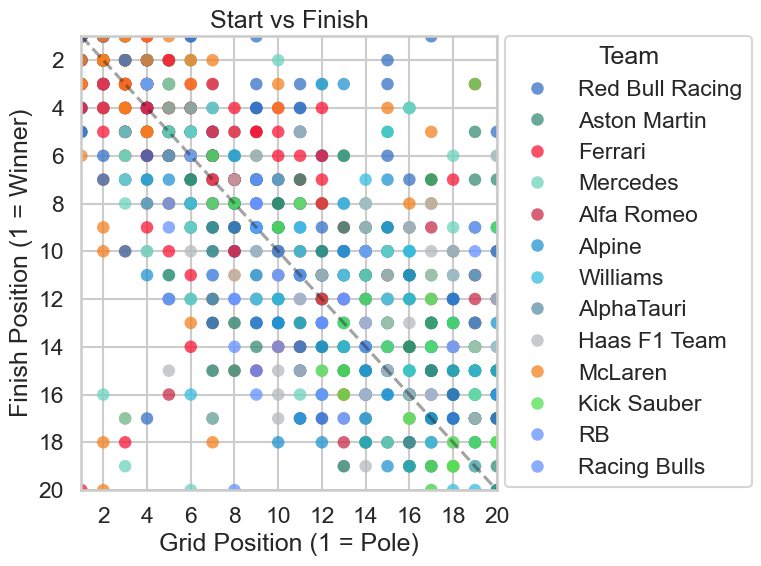

In [6]:
plot_df = df.dropna(subset=['GridPosition','ClassifiedPosition'])
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=plot_df, x='GridPosition', y='ClassifiedPosition',
    hue='TeamName', palette=team_palette if team_palette else None,
    alpha=0.75, edgecolor='none', ax=ax
)
max_pos = int(max(plot_df['GridPosition'].max(), plot_df['ClassifiedPosition'].max(), 20))
ax.plot([1, max_pos], [1, max_pos], 'k--', alpha=0.4)
ax.set(
    xlim=(1, max_pos), ylim=(max_pos, 1),
    xlabel='Grid Position (1 = Pole)', ylabel='Finish Position (1 = Winner)',
    title='Start vs Finish'
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(title='Team', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

## 2) Average Position Delta by Driver
Bar of mean (Grid − Finish); positive means positions gained.

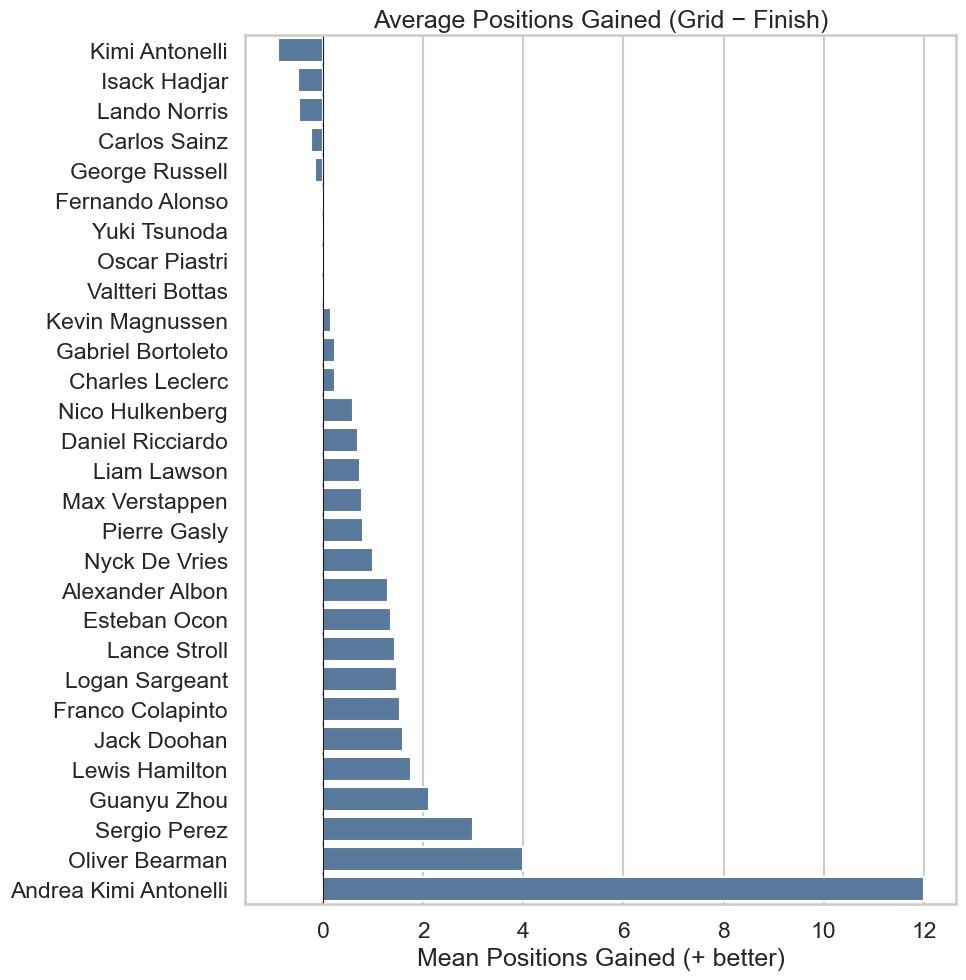

In [7]:
delta_df = df.copy()
delta_df['pos_delta'] = delta_df['GridPosition'] - delta_df['ClassifiedPosition']
mean_delta = (
    delta_df.dropna(subset=['pos_delta','FullName'])
            .groupby('FullName', as_index=False)['pos_delta']
            .mean()
)
mean_delta = mean_delta.sort_values('pos_delta', ascending=True)  # ascending for horizontal bar ordering
fig, ax = plt.subplots(figsize=(10, max(6, 0.35 * mean_delta.shape[0])))
sns.barplot(
    data=mean_delta, x='pos_delta', y='FullName', color='#4C78A8', ax=ax
)
ax.axvline(0, color='k', lw=0.8)
ax.set(
    title='Average Positions Gained (Grid − Finish)',
    xlabel='Mean Positions Gained (+ better)', ylabel=''
)
plt.tight_layout()
plt.show()

## 3) Cumulative Team Points by Round
Lines per team, faceted by season.

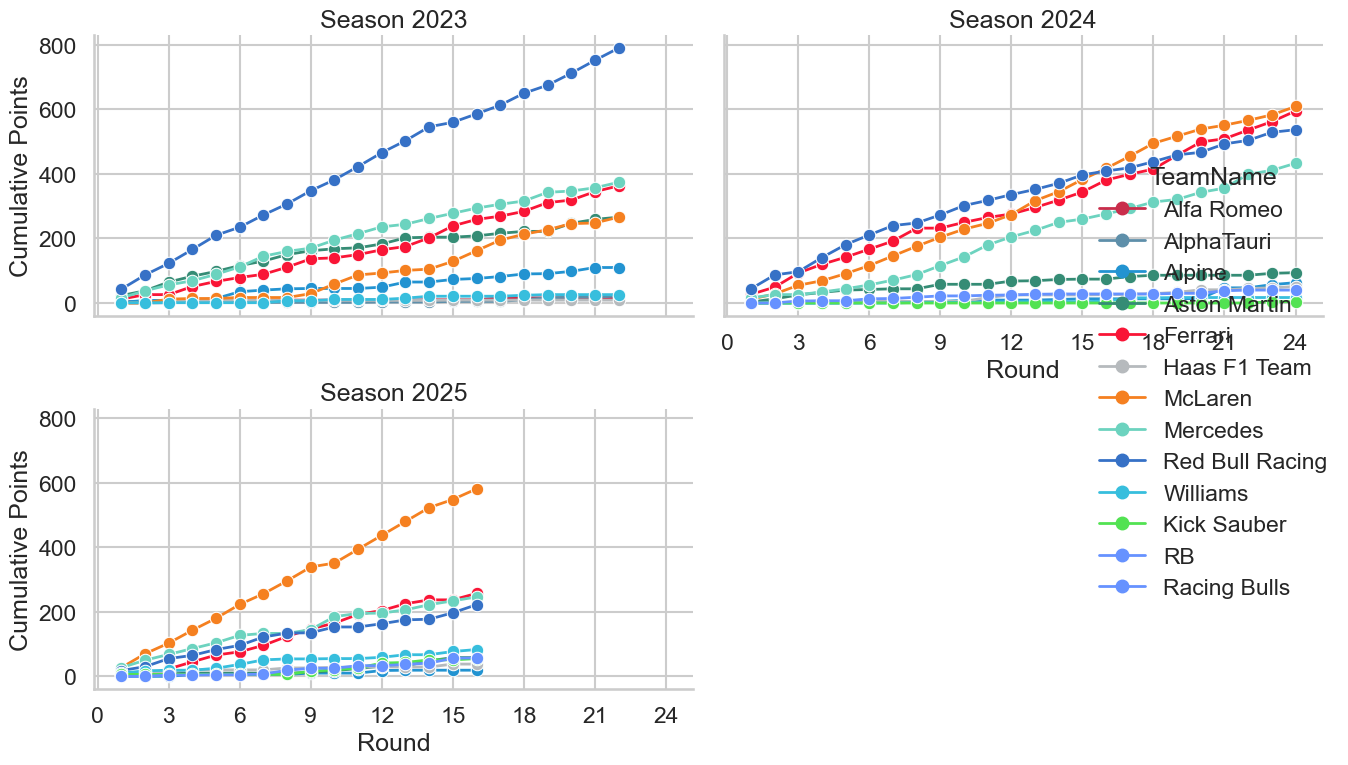

In [8]:
team_pts = (
    df.groupby(['Season','Round','TeamName'], as_index=False)['Points'].sum()
)
team_pts = team_pts.sort_values(['Season','TeamName','Round'])
team_pts['cum_points'] = team_pts.groupby(['Season','TeamName'])['Points'].cumsum()
g = sns.relplot(
    data=team_pts, kind='line', x='Round', y='cum_points', hue='TeamName',
    col='Season', col_wrap=2, height=4.0, aspect=1.4,
    palette=team_palette if team_palette else None, linewidth=2.0, marker='o'
)
g.set_axis_labels('Round', 'Cumulative Points')
g.set_titles('Season {col_name}')
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

## 4) Team Standings Bump Chart
Rank of cumulative team points by round (1 at top), faceted by season.

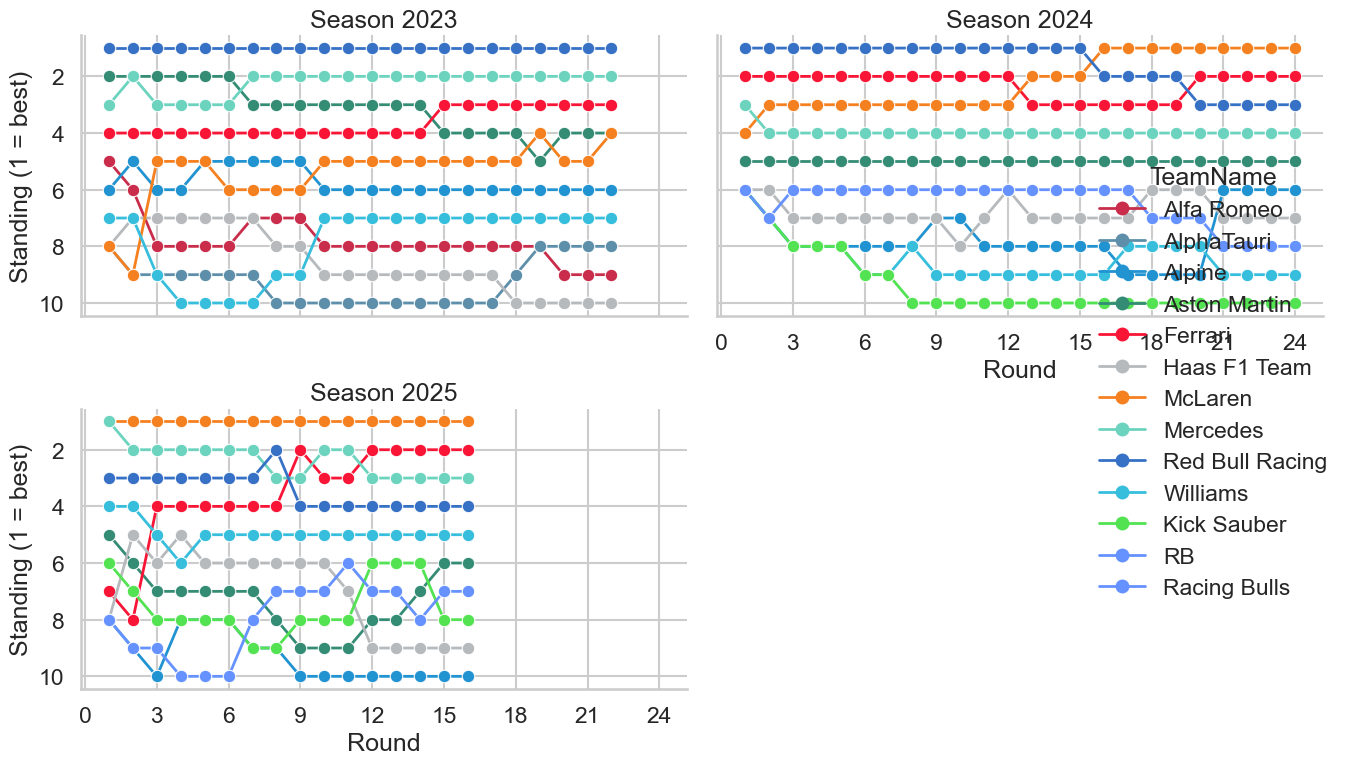

In [9]:
rank_df = team_pts.copy()
# Compute rank within each season/round on cumulative points (descending)
rank_df['rank'] = (
    rank_df.groupby(['Season','Round'])['cum_points']
           .rank(method='min', ascending=False)
)
g2 = sns.relplot(
    data=rank_df, kind='line', x='Round', y='rank', hue='TeamName',
    col='Season', col_wrap=2, height=4.0, aspect=1.4,
    palette=team_palette if team_palette else None, linewidth=2.0, marker='o'
)
g2.set_axis_labels('Round', 'Standing (1 = best)')
g2.set_titles('Season {col_name}')
for ax in g2.axes.flat:
    ax.invert_yaxis()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

## 5) Qualifying Consistency by Team
Distribution of `AvgQualiTime` by team, faceted by season.

/var/folders/1n/fyv7c6_d7yz8wf2j5ngvrj_w0000gn/T/ipykernel_91934/2841068188.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g3 = sns.catplot(


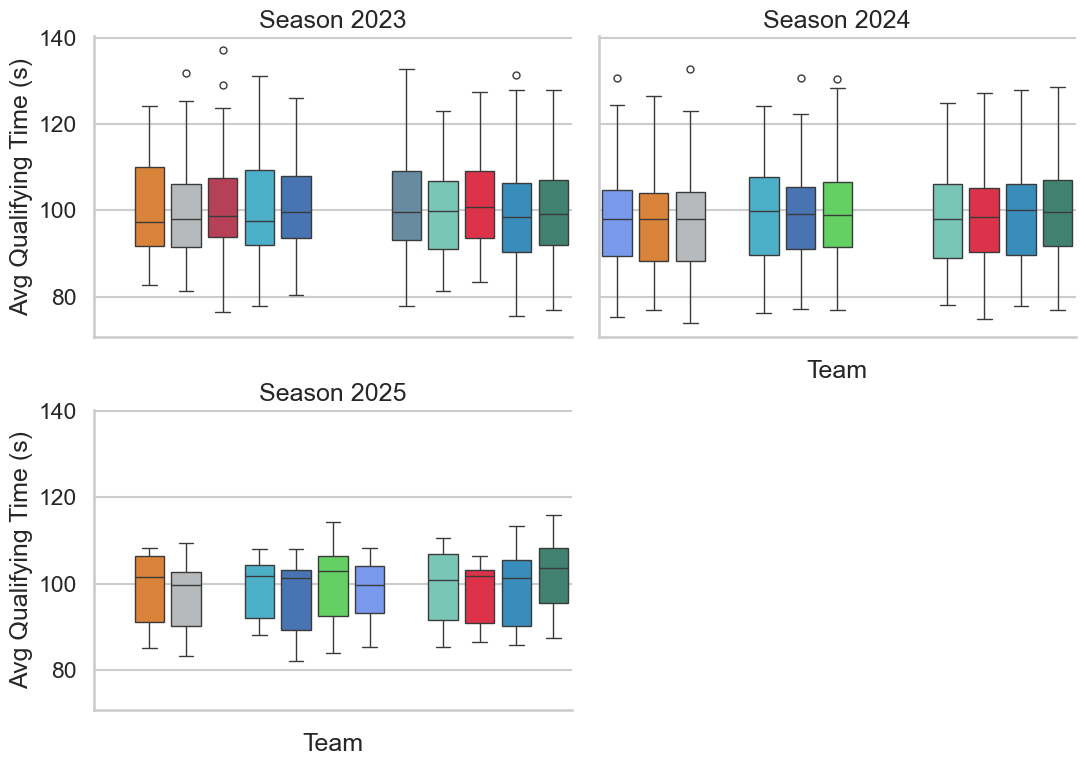

In [10]:
qdf = df.dropna(subset=['AvgQualiTime']).copy()
# Order teams by overall median qualifying time (faster to slower)
team_order = (
    qdf.groupby('TeamName')['AvgQualiTime']
       .median()
       .sort_values(ascending=True)
)
g3 = sns.catplot(
    data=qdf, x='TeamName', y='AvgQualiTime', kind='box',
    order=team_order.index, palette=team_palette if team_palette else None,
    col='Season', col_wrap=2, height=4.0, aspect=1.4
)
g3.set_xticklabels(rotation=60, ha='right')
g3.set_axis_labels('Team', 'Avg Qualifying Time (s)')
g3.set_titles('Season {col_name}')
plt.tight_layout()
plt.show()

## 6) Track Temperature vs Qualifying Pace
LOWESS trend of `TrackTemp_C` vs `AvgQualiTime`.

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

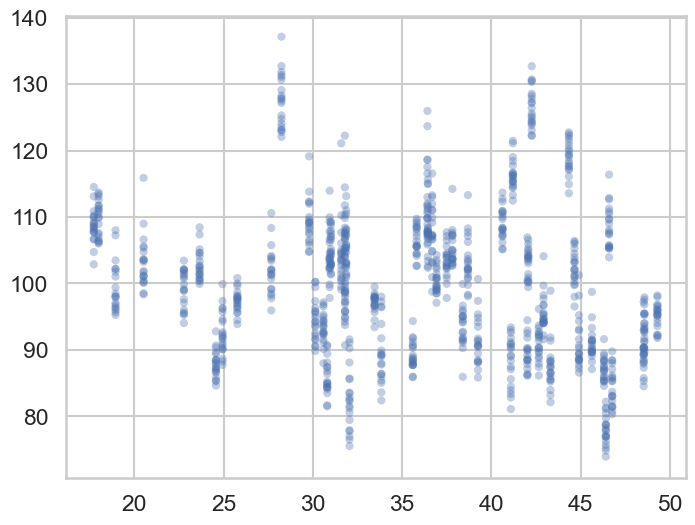

In [11]:
wx = df.dropna(subset=['TrackTemp_C','AvgQualiTime']).copy()
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(
    data=wx, x='TrackTemp_C', y='AvgQualiTime',
    lowess=True, scatter_kws={'alpha': 0.35, 's': 35, 'edgecolor': 'none'},
    line_kws={'color': 'black', 'lw': 2.0}, ax=ax
)
ax.set(title='Track Temperature vs Qualifying Pace', xlabel='Track Temperature (°C)', ylabel='Avg Qualifying Time (s)')
plt.tight_layout()
plt.show()